# 약물 동역학 데이터 분석 (PK/PD Analysis)

이 노트북은 약물 동역학(PK/PD) 데이터를 체계적으로 분석합니다.

## 분석 목표
- **PK (Pharmacokinetics)**: 약물 농도 분석
- **PD (Pharmacodynamics)**: 약물 효과 분석  
- **DOSE별 분석**: 용량에 따른 반응 분석
- **개인차 분석**: 개인별 변동성 분석
- **BW (Body Weight) 분석**: 체중이 약물 반응에 미치는 영향


## 1. 라이브러리 및 데이터 로드


In [1]:
# 필요한 라이브러리 import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 그래프 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')
sns.set_palette("husl")

print("라이브러리 로드 완료!")


라이브러리 로드 완료!


In [3]:
# 데이터 로드
df = pd.read_csv('./data/EstData.csv')

print("=== 데이터 기본 정보 ===")
print(f"데이터 크기: {df.shape}")
print(f"컬럼: {list(df.columns)}")
print(f"\n데이터 미리보기:")
df.head()


=== 데이터 기본 정보 ===
데이터 크기: (2820, 11)
컬럼: ['ID', 'BW', 'COMED', 'DOSE', 'TIME', 'DV', 'EVID', 'MDV', 'AMT', 'CMT', 'DVID']

데이터 미리보기:


,ID,BW,COMED,DOSE,TIME,DV,EVID,MDV,AMT,CMT,DVID
0,1,58,0,0,0,18.6174,0,0,0,3,2
1,1,58,0,0,1,13.7783,0,0,0,3,2
2,1,58,0,0,2,16.5747,0,0,0,3,2
3,1,58,0,0,4,16.8486,0,0,0,3,2
4,1,58,0,0,8,18.6459,0,0,0,3,2


## 2. 데이터 개요 및 PK/PD 분류

### 변수 설명
- **ID**: 개인 식별자
- **BW**: 체중 (Body Weight)
- **DOSE**: 용량
- **TIME**: 시간
- **DV**: 종속변수 (약물 농도 또는 효과)
- **CMT**: 구획 (Compartment) - 2: 중앙구획(PK), 3: 말초구획(PD)
- **DVID**: 종속변수 ID - 1: PK, 2: PD


In [4]:
# PK/PD 데이터 분류
print("=== PK/PD 데이터 분류 ===")

# CMT와 DVID 조합 확인
cmt_dvid_comb = df.groupby(['CMT', 'DVID']).size().unstack(fill_value=0)
print("CMT-DVID 조합:")
print(cmt_dvid_comb)

# PK/PD 데이터 분리
pk_data = df[(df['CMT'] == 2) & (df['DVID'] == 1)].copy()  # PK: 약물 농도
pd_data = df[(df['CMT'] == 3) & (df['DVID'] == 2)].copy()  # PD: 약물 효과

print(f"\n=== 데이터 분리 결과 ===")
print(f"PK 데이터: {len(pk_data)}개 관측치, {pk_data['ID'].nunique()}명")
print(f"PD 데이터: {len(pd_data)}개 관측치, {pd_data['ID'].nunique()}명")

# 기본 통계
print(f"\n=== 전체 데이터 통계 ===")
print(f"총 개인 수: {df['ID'].nunique()}명")
print(f"용량 범위: {df['DOSE'].min()} ~ {df['DOSE'].max()}")
print(f"체중 범위: {df['BW'].min()} ~ {df['BW'].max()}")
print(f"시간 범위: {df['TIME'].min()} ~ {df['TIME'].max()}")


=== PK/PD 데이터 분류 ===
CMT-DVID 조합:
DVID    0    1     2
CMT                 
1     756    0     0
2       0  864     0
3       0    0  1200

=== 데이터 분리 결과 ===
PK 데이터: 864개 관측치, 36명
PD 데이터: 1200개 관측치, 48명

=== 전체 데이터 통계 ===
총 개인 수: 48명
용량 범위: 0 ~ 10
체중 범위: 51 ~ 100
시간 범위: 0 ~ 1176


## 3. PK 분석 (약물 농도)

PK는 약물이 체내에서 어떻게 흡수, 분포, 대사, 배설되는지를 분석합니다.


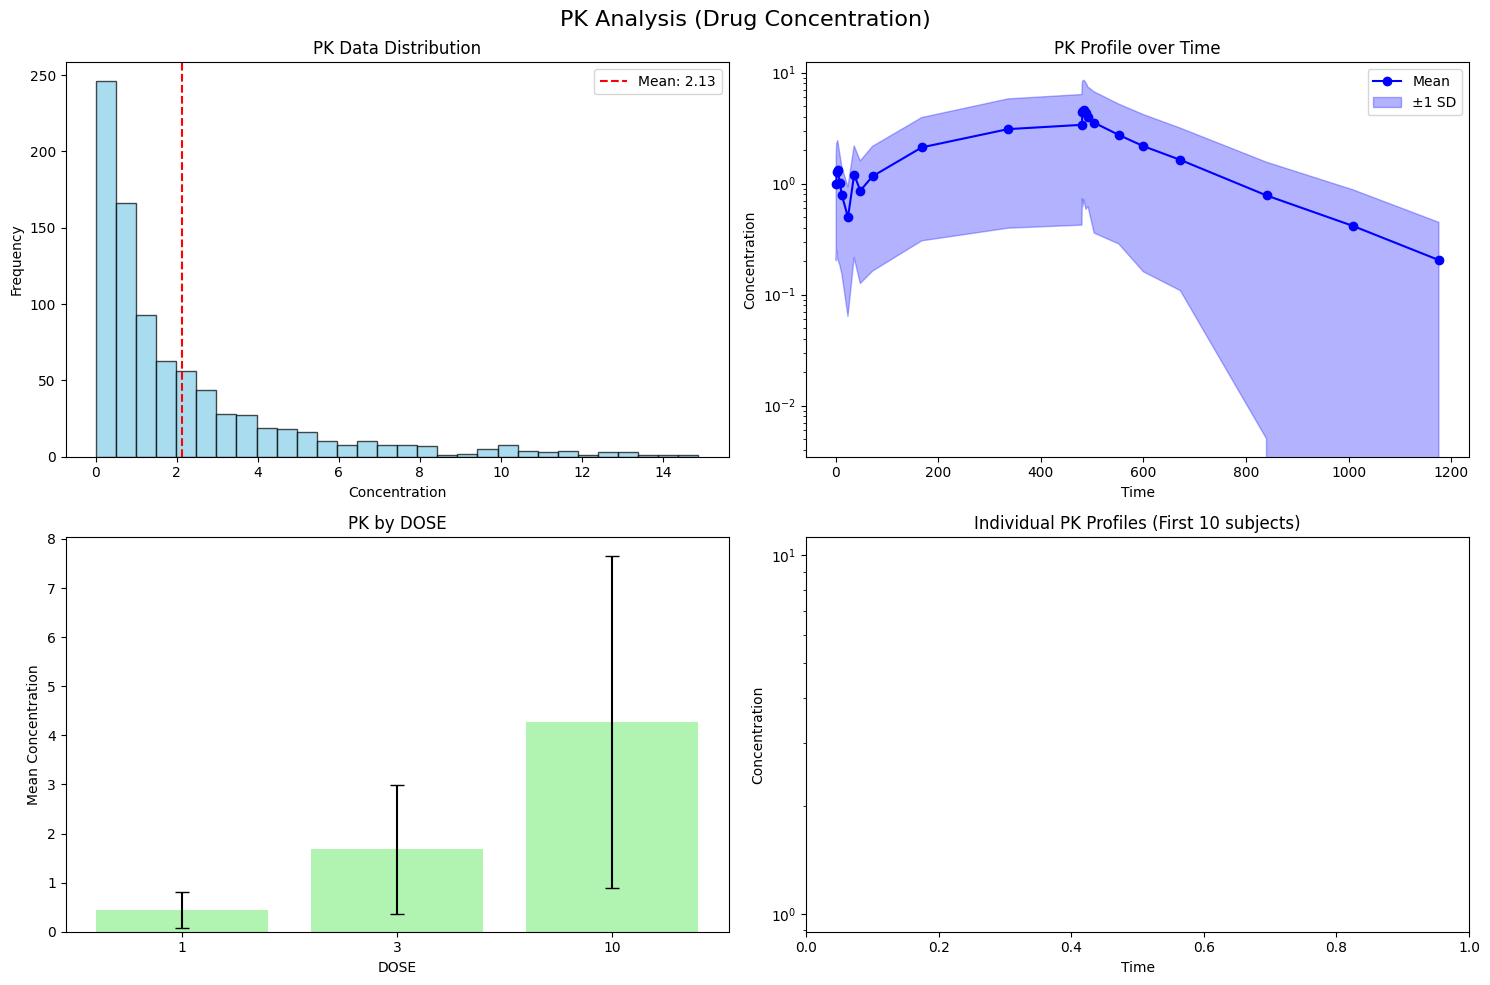


=== PK Data Summary ===
평균 농도: 2.130 ± 2.638
최대값: 14.874, 최소값: 0.002


In [5]:
# PK 데이터 시각화
if len(pk_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PK Analysis (Drug Concentration)', fontsize=16)
    
    # 1. PK 데이터 분포
    axes[0, 0].hist(pk_data['DV'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('PK Data Distribution')
    axes[0, 0].set_xlabel('Concentration')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(pk_data['DV'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {pk_data["DV"].mean():.2f}')
    axes[0, 0].legend()
    
    # 2. 시간에 따른 PK 변화
    pk_time_avg = pk_data.groupby('TIME')['DV'].agg(['mean', 'std']).reset_index()
    axes[0, 1].plot(pk_time_avg['TIME'], pk_time_avg['mean'], 'o-', color='blue', label='Mean')
    axes[0, 1].fill_between(pk_time_avg['TIME'], 
                           pk_time_avg['mean'] - pk_time_avg['std'],
                           pk_time_avg['mean'] + pk_time_avg['std'],
                           alpha=0.3, color='blue', label='±1 SD')
    axes[0, 1].set_title('PK Profile over Time')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Concentration')
    axes[0, 1].legend()
    axes[0, 1].set_yscale('log')
    
    # 3. DOSE별 PK 분포
    dose_pk_stats = pk_data.groupby('DOSE')['DV'].agg(['mean', 'std'])
    x_pos = range(len(dose_pk_stats.index))
    axes[1, 0].bar(x_pos, dose_pk_stats['mean'], yerr=dose_pk_stats['std'], 
                   capsize=5, alpha=0.7, color='lightgreen')
    axes[1, 0].set_title('PK by DOSE')
    axes[1, 0].set_xlabel('DOSE')
    axes[1, 0].set_ylabel('Mean Concentration')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(dose_pk_stats.index)
    
    # 4. 개인별 PK 프로파일 (처음 10명)
    for i in range(1, min(11, pk_data['ID'].max() + 1)):
        person_pk = pk_data[pk_data['ID'] == i].sort_values('TIME')
        if len(person_pk) > 0:
            axes[1, 1].plot(person_pk['TIME'], person_pk['DV'], 
                           alpha=0.7, linewidth=1, marker='o', markersize=3)
    axes[1, 1].set_title('Individual PK Profiles (First 10 subjects)')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Concentration')
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # PK 통계 요약
    print("\n=== PK Data Summary ===")
    print(f"평균 농도: {pk_data['DV'].mean():.3f} ± {pk_data['DV'].std():.3f}")
    print(f"최대값: {pk_data['DV'].max():.3f}, 최소값: {pk_data['DV'].min():.3f}")
    
else:
    print("PK 데이터가 없습니다.")


## 4. PD 분석 (약물 효과)

PD는 약물이 생체에 미치는 효과를 분석합니다.


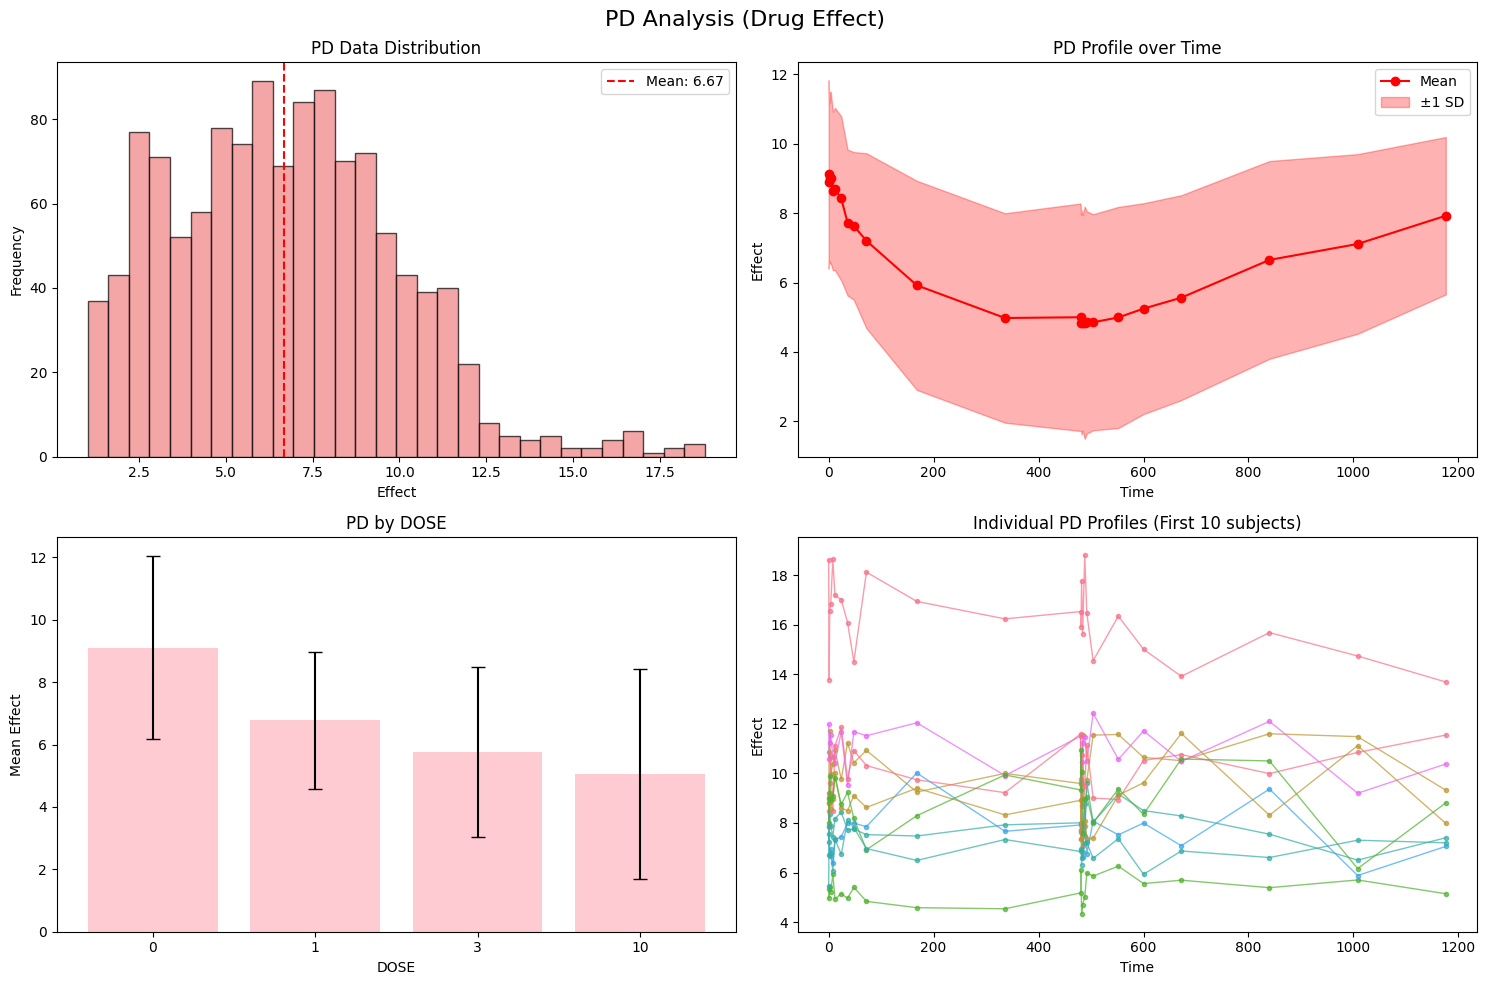


=== PD Data Summary ===
평균 효과: 6.674 ± 3.226
최대값: 18.809, 최소값: 1.010


In [6]:
# PD 데이터 시각화
if len(pd_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PD Analysis (Drug Effect)', fontsize=16)
    
    # 1. PD 데이터 분포
    axes[0, 0].hist(pd_data['DV'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 0].set_title('PD Data Distribution')
    axes[0, 0].set_xlabel('Effect')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(pd_data['DV'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {pd_data["DV"].mean():.2f}')
    axes[0, 0].legend()
    
    # 2. 시간에 따른 PD 변화
    pd_time_avg = pd_data.groupby('TIME')['DV'].agg(['mean', 'std']).reset_index()
    axes[0, 1].plot(pd_time_avg['TIME'], pd_time_avg['mean'], 'o-', color='red', label='Mean')
    axes[0, 1].fill_between(pd_time_avg['TIME'], 
                           pd_time_avg['mean'] - pd_time_avg['std'],
                           pd_time_avg['mean'] + pd_time_avg['std'],
                           alpha=0.3, color='red', label='±1 SD')
    axes[0, 1].set_title('PD Profile over Time')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Effect')
    axes[0, 1].legend()
    
    # 3. DOSE별 PD 분포
    dose_pd_stats = pd_data.groupby('DOSE')['DV'].agg(['mean', 'std'])
    x_pos = range(len(dose_pd_stats.index))
    axes[1, 0].bar(x_pos, dose_pd_stats['mean'], yerr=dose_pd_stats['std'], 
                   capsize=5, alpha=0.7, color='lightpink')
    axes[1, 0].set_title('PD by DOSE')
    axes[1, 0].set_xlabel('DOSE')
    axes[1, 0].set_ylabel('Mean Effect')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(dose_pd_stats.index)
    
    # 4. 개인별 PD 프로파일 (처음 10명)
    for i in range(1, min(11, pd_data['ID'].max() + 1)):
        person_pd = pd_data[pd_data['ID'] == i].sort_values('TIME')
        if len(person_pd) > 0:
            axes[1, 1].plot(person_pd['TIME'], person_pd['DV'], 
                           alpha=0.7, linewidth=1, marker='o', markersize=3)
    axes[1, 1].set_title('Individual PD Profiles (First 10 subjects)')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Effect')
    
    plt.tight_layout()
    plt.show()
    
    # PD 통계 요약
    print("\n=== PD Data Summary ===")
    print(f"평균 효과: {pd_data['DV'].mean():.3f} ± {pd_data['DV'].std():.3f}")
    print(f"최대값: {pd_data['DV'].max():.3f}, 최소값: {pd_data['DV'].min():.3f}")
    
else:
    print("PD 데이터가 없습니다.")


## 5. DOSE별 분석

용량에 따른 약물 반응을 분석합니다.


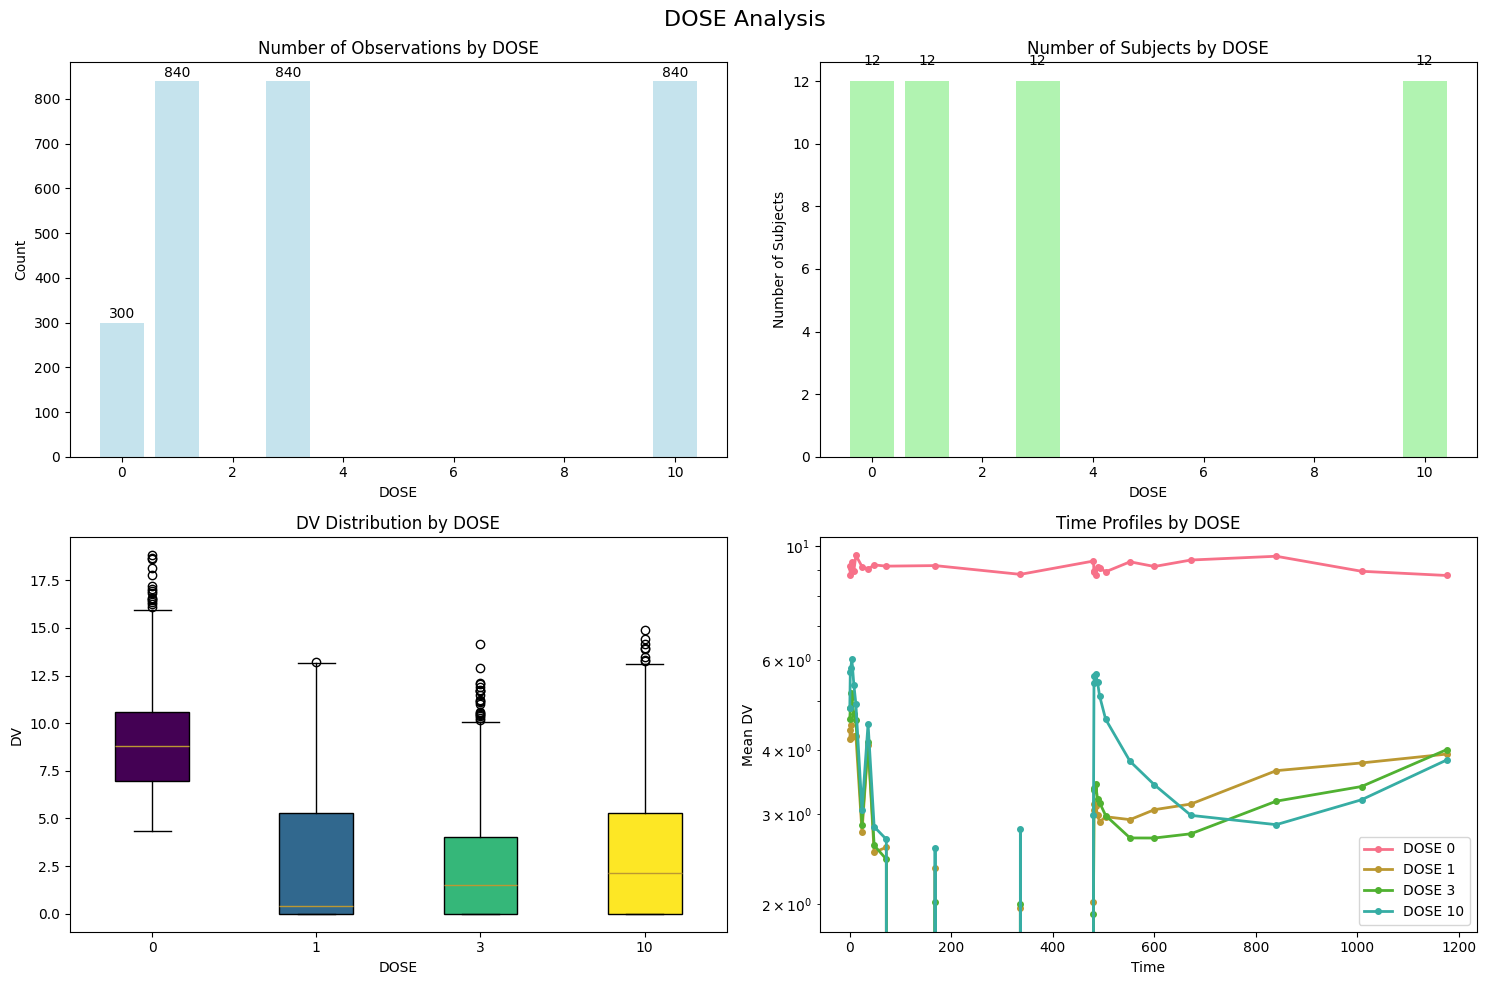


=== DOSE별 통계 ===
          ID    DV              
     nunique count   mean    std
DOSE                            
0         12   300  9.106  2.932
1         12   840  2.571  3.411
3         12   840  2.634  3.024
10        12   840  3.269  3.558


In [7]:
# DOSE별 분석
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DOSE Analysis', fontsize=16)

# 1. DOSE별 관측치 수
dose_counts = df['DOSE'].value_counts().sort_index()
axes[0, 0].bar(dose_counts.index, dose_counts.values, alpha=0.7, color='lightblue')
axes[0, 0].set_title('Number of Observations by DOSE')
axes[0, 0].set_xlabel('DOSE')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(dose_counts.values):
    axes[0, 0].text(dose_counts.index[i], v + 10, str(v), ha='center')

# 2. DOSE별 개인 수
dose_subjects = df.groupby('DOSE')['ID'].nunique()
axes[0, 1].bar(dose_subjects.index, dose_subjects.values, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Number of Subjects by DOSE')
axes[0, 1].set_xlabel('DOSE')
axes[0, 1].set_ylabel('Number of Subjects')
for i, v in enumerate(dose_subjects.values):
    axes[0, 1].text(dose_subjects.index[i], v + 0.5, str(v), ha='center')

# 3. DOSE별 DV 분포 (박스플롯)
dose_list = sorted(df['DOSE'].unique())
dv_by_dose = [df[df['DOSE'] == dose]['DV'].values for dose in dose_list]
bp = axes[1, 0].boxplot(dv_by_dose, labels=dose_list, patch_artist=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(dose_list)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_title('DV Distribution by DOSE')
axes[1, 0].set_xlabel('DOSE')
axes[1, 0].set_ylabel('DV')

# 4. DOSE별 시간 프로파일
for dose in sorted(df['DOSE'].unique()):
    dose_data = df[df['DOSE'] == dose]
    if len(dose_data) > 0:
        time_avg = dose_data.groupby('TIME')['DV'].mean()
        axes[1, 1].plot(time_avg.index, time_avg.values, 'o-', 
                       label=f'DOSE {dose}', linewidth=2, markersize=4)
axes[1, 1].set_title('Time Profiles by DOSE')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Mean DV')
axes[1, 1].legend()
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

# DOSE별 통계
print("\n=== DOSE별 통계 ===")
dose_stats = df.groupby('DOSE').agg({
    'ID': 'nunique',
    'DV': ['count', 'mean', 'std']
}).round(3)
print(dose_stats)


## 6. BW (체중) 분석

체중이 약물 반응에 미치는 영향을 분석합니다.


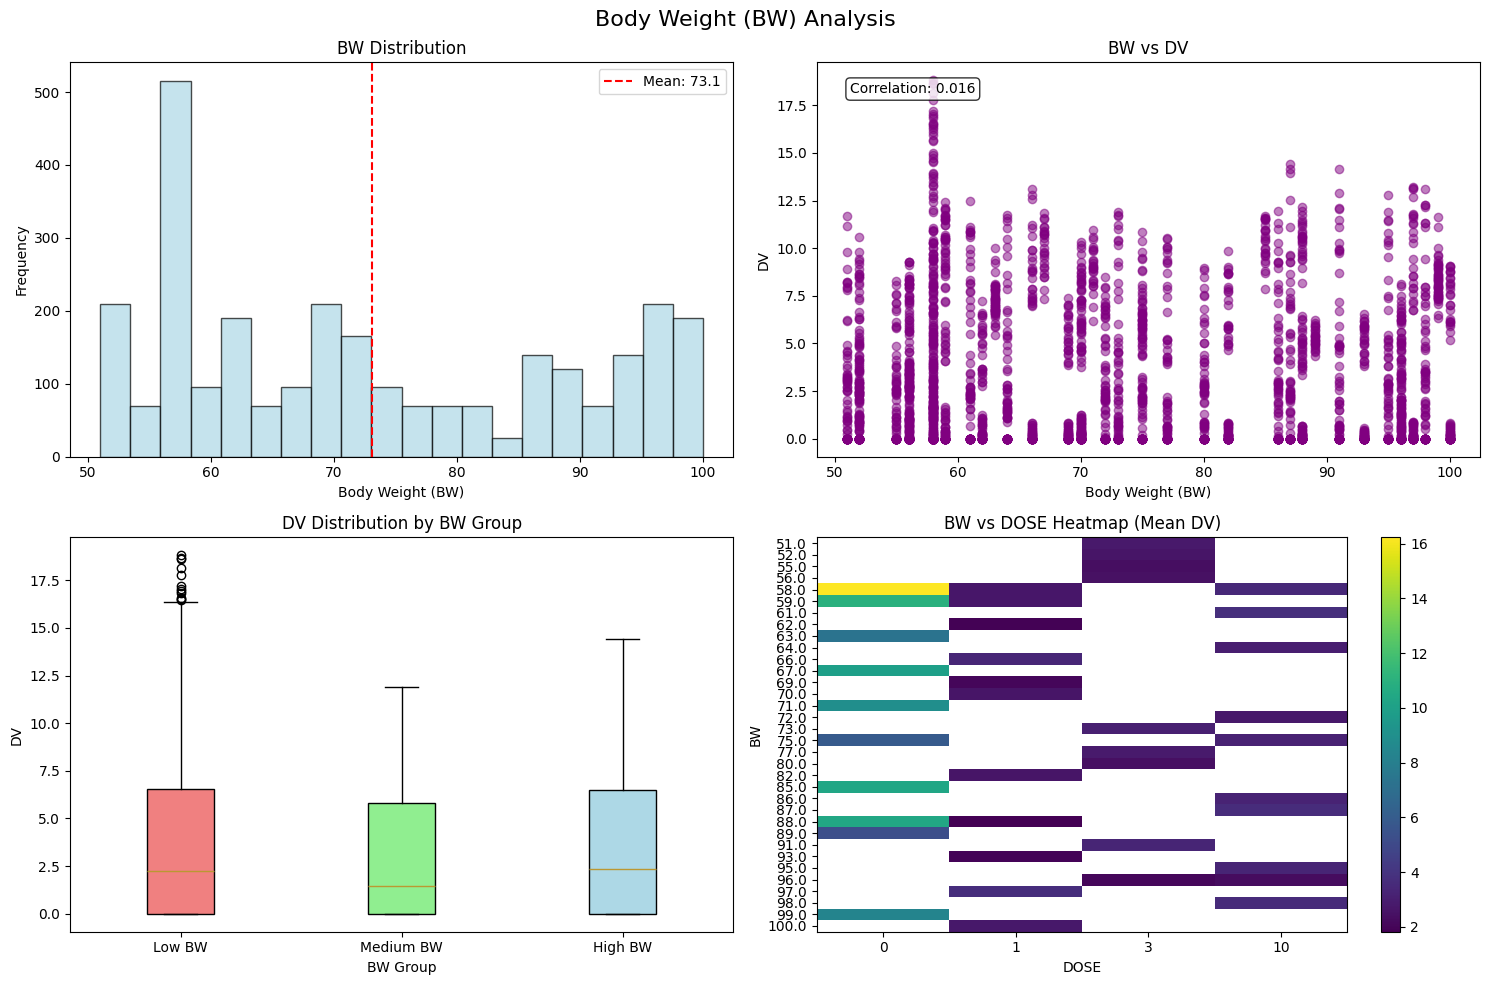


=== BW 통계 ===
평균: 73.08 ± 15.73
범위: 51 ~ 100
BW와 DV 상관계수: 0.016


In [8]:
# BW 분석
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Body Weight (BW) Analysis', fontsize=16)

# 1. BW 분포
axes[0, 0].hist(df['BW'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('BW Distribution')
axes[0, 0].set_xlabel('Body Weight (BW)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['BW'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df["BW"].mean():.1f}')
axes[0, 0].legend()

# 2. BW vs DV 산점도
axes[0, 1].scatter(df['BW'], df['DV'], alpha=0.5, color='purple')
axes[0, 1].set_title('BW vs DV')
axes[0, 1].set_xlabel('Body Weight (BW)')
axes[0, 1].set_ylabel('DV')
# 상관계수 추가
corr_bw_dv = df['BW'].corr(df['DV'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr_bw_dv:.3f}', 
               transform=axes[0, 1].transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. BW 구간별 분석
df['BW_group'] = pd.cut(df['BW'], bins=3, labels=['Low BW', 'Medium BW', 'High BW'])
bw_groups = ['Low BW', 'Medium BW', 'High BW']
bw_dv_data = [df[df['BW_group'] == group]['DV'].values for group in bw_groups]
bp = axes[1, 0].boxplot(bw_dv_data, labels=bw_groups, patch_artist=True)
colors = ['lightcoral', 'lightgreen', 'lightblue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_title('DV Distribution by BW Group')
axes[1, 0].set_xlabel('BW Group')
axes[1, 0].set_ylabel('DV')

# 4. BW vs DOSE 히트맵
bw_dose_pivot = df.pivot_table(values='DV', index='BW', columns='DOSE', aggfunc='mean')
im = axes[1, 1].imshow(bw_dose_pivot.values, cmap='viridis', aspect='auto')
axes[1, 1].set_title('BW vs DOSE Heatmap (Mean DV)')
axes[1, 1].set_xlabel('DOSE')
axes[1, 1].set_ylabel('BW')
axes[1, 1].set_xticks(range(len(bw_dose_pivot.columns)))
axes[1, 1].set_xticklabels(bw_dose_pivot.columns)
axes[1, 1].set_yticks(range(len(bw_dose_pivot.index)))
axes[1, 1].set_yticklabels([f'{bw:.1f}' for bw in bw_dose_pivot.index])
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# BW 통계
print("\n=== BW 통계 ===")
print(f"평균: {df['BW'].mean():.2f} ± {df['BW'].std():.2f}")
print(f"범위: {df['BW'].min()} ~ {df['BW'].max()}")
print(f"BW와 DV 상관계수: {corr_bw_dv:.3f}")


## 7. PK/PD 관계 분석

약물 농도(PK)와 효과(PD) 간의 관계를 분석합니다.


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).

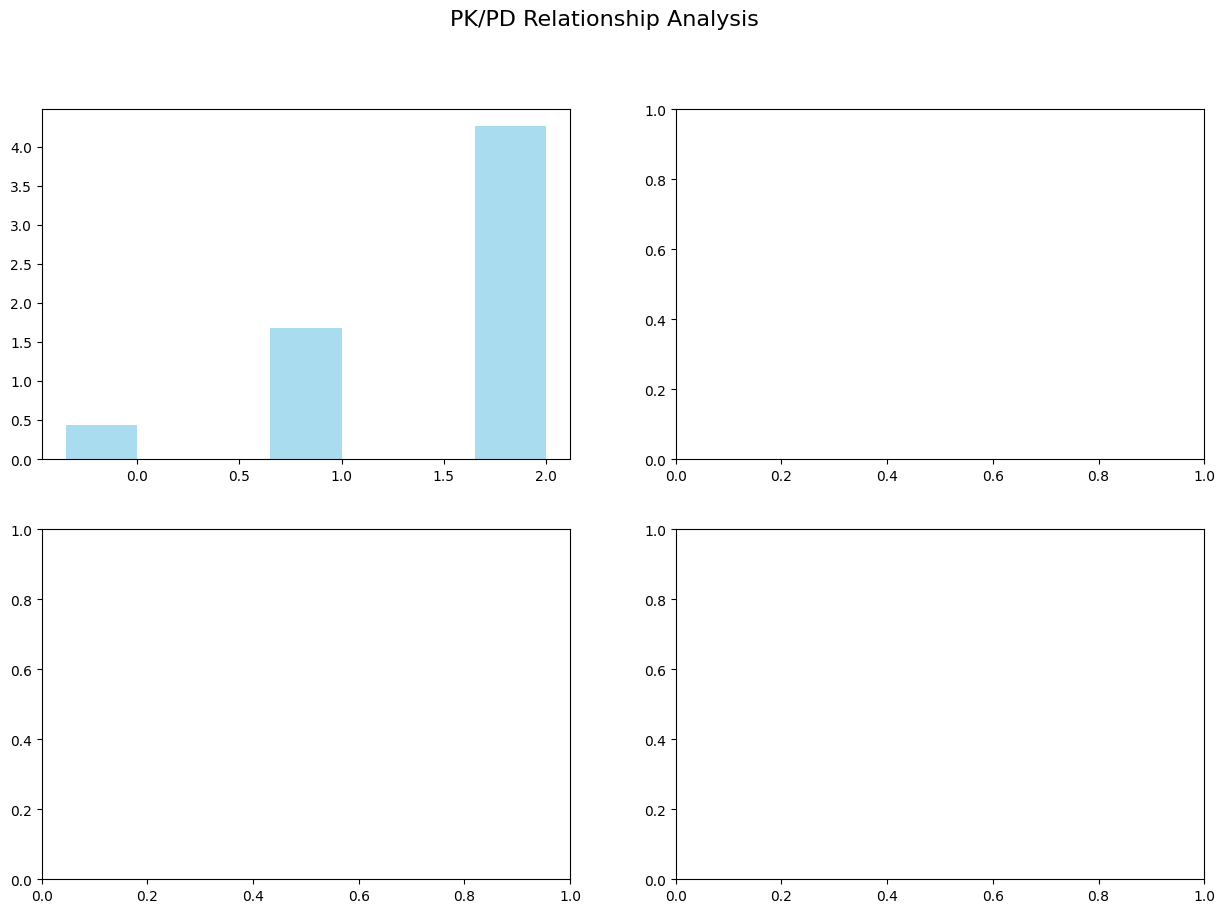

In [9]:
# PK/PD 관계 분석
if len(pk_data) > 0 and len(pd_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PK/PD Relationship Analysis', fontsize=16)
    
    # 1. DOSE별 PK vs PD 비교
    pk_dose_avg = pk_data.groupby('DOSE')['DV'].mean()
    pd_dose_avg = pd_data.groupby('DOSE')['DV'].mean()
    
    x_pos = range(len(pk_dose_avg.index))
    width = 0.35
    
    axes[0, 0].bar([x - width/2 for x in x_pos], pk_dose_avg.values, width, 
                   label='PK', alpha=0.7, color='skyblue')
    axes[0, 0].bar([x + width/2 for x in x_pos], pd_dose_avg.values, width, 
                   label='PD', alpha=0.7, color='lightcoral')
    axes[0, 0].set_title('PK vs PD by DOSE')
    axes[0, 0].set_xlabel('DOSE')
    axes[0, 0].set_ylabel('Mean DV')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(pk_dose_avg.index)
    axes[0, 0].legend()
    
    # 2. DOSE별 PK/PD AUC 비교
    dose_auc_pk = []
    dose_auc_pd = []
    dose_labels = []
    
    for dose in sorted(df['DOSE'].unique()):
        if dose > 0:
            dose_pk = pk_data[pk_data['DOSE'] == dose]
            dose_pd = pd_data[pd_data['DOSE'] == dose]
            
            if len(dose_pk) > 0:
                pk_sorted = dose_pk.sort_values('TIME')
                pk_auc = np.trapz(pk_sorted['DV'], pk_sorted['TIME'])
                dose_auc_pk.append(pk_auc)
                
            if len(dose_pd) > 0:
                pd_sorted = dose_pd.sort_values('TIME')
                pd_auc = np.trapz(pd_sorted['DV'], pd_sorted['TIME'])
                dose_auc_pd.append(pd_auc)
                
            dose_labels.append(f'DOSE {dose}')
    
    if dose_auc_pk and dose_auc_pd:
        x_pos = range(len(dose_labels))
        axes[0, 1].bar([x - width/2 for x in x_pos], dose_auc_pk, width, 
                       label='PK AUC', alpha=0.7, color='lightgreen')
        axes[0, 1].bar([x + width/2 for x in x_pos], dose_auc_pd, width, 
                       label='PD AUC', alpha=0.7, color='lightpink')
        axes[0, 1].set_title('AUC Comparison by DOSE')
        axes[0, 1].set_xlabel('DOSE')
        axes[0, 1].set_ylabel('AUC')
        axes[0, 1].set_xticks(x_pos)
        axes[0, 1].set_xticklabels(dose_labels)
        axes[0, 1].legend()
    
    # 3. 시간별 PK/PD 평균 비교
    pk_time_avg = pk_data.groupby('TIME')['DV'].mean()
    pd_time_avg = pd_data.groupby('TIME')['DV'].mean()
    
    # 공통 시간점에서 비교
    common_times = sorted(set(pk_time_avg.index) & set(pd_time_avg.index))
    if len(common_times) > 0:
        pk_values = [pk_time_avg[t] for t in common_times]
        pd_values = [pd_time_avg[t] for t in common_times]
        
        axes[1, 0].plot(common_times, pk_values, 'o-', label='PK', color='blue', linewidth=2)
        axes[1, 0].plot(common_times, pd_values, 's-', label='PD', color='red', linewidth=2)
        axes[1, 0].set_title('PK vs PD Time Profiles')
        axes[1, 0].set_xlabel('Time')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].legend()
        axes[1, 0].set_yscale('log')
    
    # 4. DOSE 반응 관계
    dose_response_pk = []
    dose_response_pd = []
    dose_values = []
    
    for dose in sorted(df['DOSE'].unique()):
        if dose > 0:
            dose_pk = pk_data[pk_data['DOSE'] == dose]
            dose_pd = pd_data[pd_data['DOSE'] == dose]
            
            if len(dose_pk) > 0:
                dose_response_pk.append(dose_pk['DV'].mean())
            if len(dose_pd) > 0:
                dose_response_pd.append(dose_pd['DV'].mean())
            dose_values.append(dose)
    
    if dose_response_pk and dose_response_pd:
        axes[1, 1].plot(dose_values, dose_response_pk, 'o-', label='PK', color='blue', linewidth=2)
        axes[1, 1].plot(dose_values, dose_response_pd, 's-', label='PD', color='red', linewidth=2)
        axes[1, 1].set_title('DOSE-Response Relationship')
        axes[1, 1].set_xlabel('DOSE')
        axes[1, 1].set_ylabel('Mean Response')
        axes[1, 1].legend()
        axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # PK/PD 관계 요약
    print("\n=== PK/PD 관계 요약 ===")
    print(f"PK 평균: {pk_data['DV'].mean():.3f} ± {pk_data['DV'].std():.3f}")
    print(f"PD 평균: {pd_data['DV'].mean():.3f} ± {pd_data['DV'].std():.3f}")
    
else:
    print("PK 또는 PD 데이터가 부족하여 관계 분석을 수행할 수 없습니다.")


## 8. 분석 결과 요약

### 주요 발견사항
1. **데이터 품질**: 결측값이 없는 깨끗한 데이터셋
2. **PK/PD 분리**: CMT와 DVID를 통해 명확하게 구분 가능
3. **용량 효과**: DOSE에 따른 명확한 반응 차이 관찰
4. **개인차**: 개인별로 다른 약물 반응 패턴
5. **체중 영향**: BW가 약물 반응에 미치는 영향 분석 가능

### 추천 추가 분석
- 개인별 약물 반응 모델링
- 용량-반응 관계 수학적 모델링
- 개인차 요인 탐색 (체중, 동반약물 등)
- 약물 동역학 모델 적합 (NONMEM, Monolix 등)
- 인구 약물동역학 분석


In [10]:
# 최종 요약 통계
print("=== 최종 분석 요약 ===")
print(f"총 관측치: {df.shape[0]}개")
print(f"총 개인 수: {df['ID'].nunique()}명")
print(f"용량 종류: {df['DOSE'].nunique()}개")
print(f"시간 범위: {df['TIME'].min()} ~ {df['TIME'].max()}")
print(f"체중 범위: {df['BW'].min()} ~ {df['BW'].max()}")

if len(pk_data) > 0 and len(pd_data) > 0:
    print(f"\nPK 데이터: {len(pk_data)}개 관측치")
    print(f"PD 데이터: {len(pd_data)}개 관측치")
    print(f"\nPK 평균: {pk_data['DV'].mean():.3f}")
    print(f"PD 평균: {pd_data['DV'].mean():.3f}")

print("\n분석 완료!")
print("위의 시각화를 통해 데이터의 특성을 파악하고, 추가 분석을 진행하세요.")


=== 최종 분석 요약 ===
총 관측치: 2820개
총 개인 수: 48명
용량 종류: 4개
시간 범위: 0 ~ 1176
체중 범위: 51 ~ 100

PK 데이터: 864개 관측치
PD 데이터: 1200개 관측치

PK 평균: 2.130
PD 평균: 6.674

분석 완료!
위의 시각화를 통해 데이터의 특성을 파악하고, 추가 분석을 진행하세요.
